In [2]:
"""
downloading dataset from mnist official website.

"""
import numpy as np
import requests 
import os
import time
from tqdm import tqdm
from tqdm import trange
import gzip
import hashlib

In [14]:
def download(link):
    
    path = os.path.join("/tmp", hashlib.md5(link.encode('utf-8')).hexdigest())
    if os.path.isfile(path):
        with open(path, "rb") as file:
          data = file.read()
    else:
        with open(path, "wb") as file:
          data = requests.get(link).content
          file.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
        

In [40]:
x_train = download("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28))
y_train = download("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
x_test = download("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = download("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [41]:
print(f"shape of x_train is {x_train.shape}")
print(f"shape of x_test is {x_test.shape}")
print(f"shape of y_train is {y_train.shape}")
print(f"shape of y_test is {y_test.shape}")

shape of x_train is (60000, 28, 28)
shape of x_test is (10000, 28, 28)
shape of y_train is (60000,)
shape of y_test is (10000,)


3


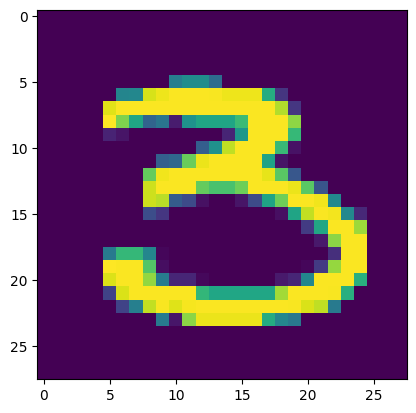

In [177]:
rand_idx = np.random.randint(0,x_train.shape[0])
img = x_train[rand_idx]
plt.imshow(img)
label = y_train[rand_idx]
print(label)

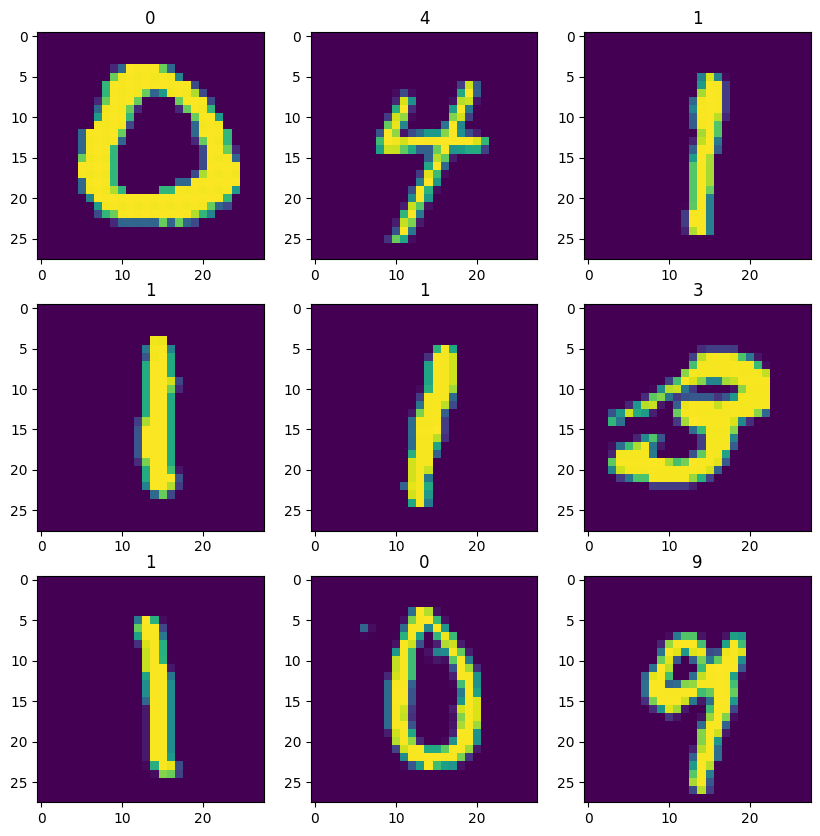

In [179]:
"""
image visualization
"""
import matplotlib.pyplot as plt
def draw_image(data,y_train):
    figure = plt.figure(figsize=(10,10))
    row,col = 3,3
    for i in range(1,row*col+1):
        rand_idx = np.random.randint(0,data.shape[0])
        img = data[rand_idx]
        plt.subplot(row,col,i)
        plt.imshow(img)
        label = y_train[rand_idx]
        plt.title(label)
      

draw_image(x_train,y_train)


In [149]:
"""
    model building using pytorch

"""
import torch 
from torch.nn import Linear
from torch import nn
import torch.nn.functional as ptfunc
from torch.nn import Sequential

class Deepnet(torch.nn.Module):

    def __init__(self):
        super(Deepnet,self).__init__()
        self.layer1 = Linear(784,100)
        self.layer2 = Linear(100,10)
        self.layer3 = nn.LogSoftmax(dim=1)

    def forward(self,x):

        norm = self.layer1(x)
        norm = torch.nn.functional.relu(norm)
        norm = self.layer2(norm)
        norm = self.layer3(norm)
        return norm
model = Deepnet()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum = 0)

print(f"model is {model}")
print(f"optimizer is {optimizer}")
print(f"loss function is {loss_function}")

model is Deepnet(
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=10, bias=True)
  (layer3): LogSoftmax(dim=1)
)
optimizer is SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
loss function is CrossEntropyLoss()


In [150]:
"""
training over the data on the given data
"""
batch_size = 32
epochs = 500
loss_ = []
accuracy_ = []
for i in (t:= trange(epochs)):
    index = np.random.randint(0,x_train.shape[0],size=64)
    x = torch.tensor(x_train[index].reshape(-1,28*28)).float()
    y = torch.tensor(y_train[index]).long()
    model.zero_grad()
    y_pred = model(x)
    prediction = torch.argmax(y_pred,dim=1)
    accuracy = (prediction == y).float().mean() 
    loss = loss_function(y_pred,y)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    loss,accu = loss.item(),accuracy.item()
    loss_.append(loss)
    accuracy_.append(accu)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accu))
    


loss 0.21 accuracy 0.92: 100%|███████████████| 500/500 [00:01<00:00, 366.09it/s]


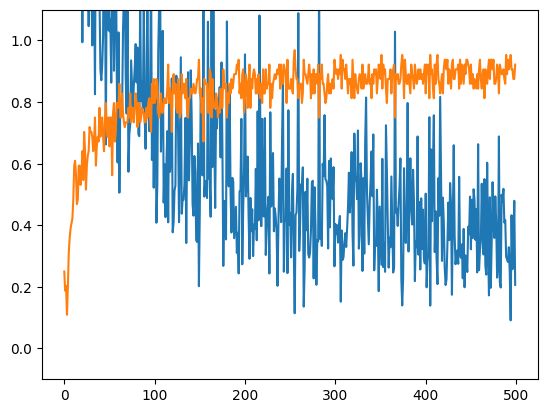

In [154]:
"""
plotting the graph
"""
import matplotlib.pyplot as plt
plt.ylim(-0.1, 1.1)
plt.plot(loss_)
img = plt.plot(accuracy_)
plt.savefig('accuracy.png')

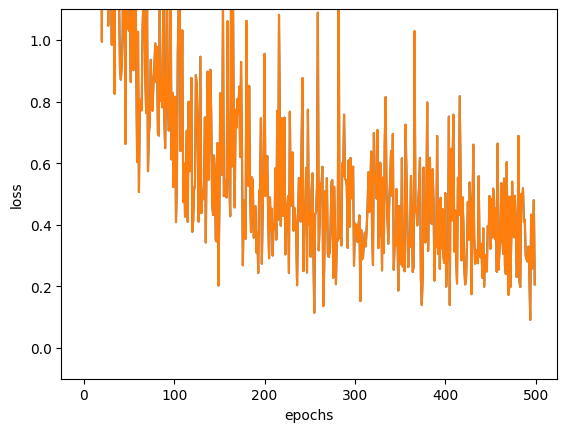

In [156]:
import matplotlib.pyplot as plt
plt.ylim(-0.1, 1.1)
plt.plot(loss_)
img = plt.plot(loss_)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.savefig('loss.png')

In [160]:
"""
evaluating the model
"""
y_test_preds = torch.argmax(model(torch.tensor(x_test.reshape((-1, 28*28))).float()), dim=1).numpy()
print(f"accuracy of model is {(y_test == y_test_preds).mean()*100}%")


accuracy of model is 90.4%


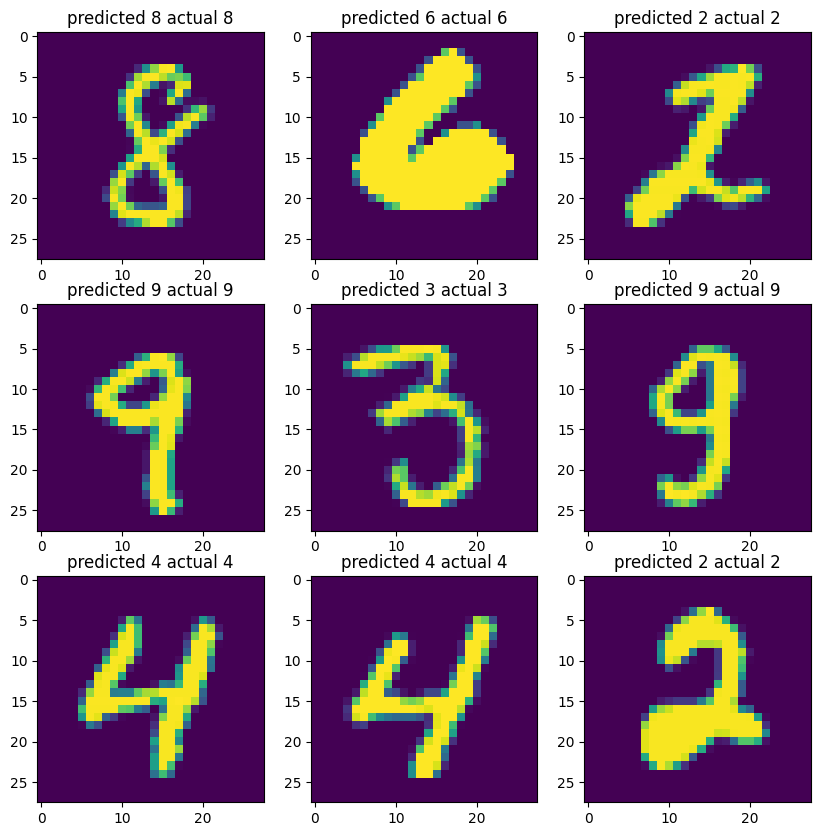

In [194]:
"""
    validating how model works
"""
def draw_predicted_img(model,x_test,y_test):
    row , col = 3,3
    figure = plt.figure(figsize=(10,10))
    for i in range(1,row*col+1):
        idx = np.random.randint(0,x_test.shape[0])
        image = x_test[idx]
        img =torch.tensor( x_test[idx].reshape(-1,28*28)).float()
        y_predict = torch.argmax(model(img),dim=1).numpy()
        plt.subplot(row,col,i)
        plt.imshow(image)
        label = y_test[idx]
        plt.title(f"predicted {y_predict[0]} actual {label}")
        plt.savefig("ouput.png")

draw_predicted_img(model,x_test,y_test)